In [1]:
import pickle
import sys
from collections import defaultdict
from pathlib import Path

import cv2
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.cluster.hierarchy as sch
import seaborn as sns
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1.inset_locator import mark_inset, zoomed_inset_axes
from skimage import measure, exposure
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from typing import List
import skimage
from operator import itemgetter 

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Import path
module_path = str(Path.cwd().parents[0])
if module_path not in sys.path:
    sys.path.append(module_path)

module_path = str(Path.cwd().parents[0] / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
import utils as utils
from config import *

In [5]:
csv_file = data_meta / "info_combined.csv"

# Read dataframe containing images information
df = pd.read_csv(csv_file)

In [6]:
scaler = StandardScaler()

# Read intensity per cell and scale data

In [7]:
df_intensity = pd.read_csv(data_meta / "measurements_intensity.csv")
df_morph = pd.read_csv(data_meta / "measurements_morphology.csv")
markers = df_intensity.Marker.unique()

In [8]:
# Calculate total intensity from mena intensity and area size
for row in df_intensity.itertuples():
    cond = row.Location
    i = row.Id
    total_nuclei_intensity = (
        row.Nuclei_mean_intensity
        * df_morph[(df_morph.Location == cond) & (df_morph.Id == i)][
            "Nuclei_area"
        ].item()
    )
    total_cyto_intensity = (
        row.Cyto_mean_intensity
        * df_morph[(df_morph.Location == cond) & (df_morph.Id == i)]["Cyto_area"].item()
    )
    df_intensity.loc[row.Index, "Nuclei_total_intensity"] = total_nuclei_intensity
    df_intensity.loc[row.Index, "Cyto_total_intensity"] = total_cyto_intensity

In [9]:
df_intensity = df_intensity[~df_intensity.Marker.isin(['Hoeschst', "WGA", 'Phalloidin', 'B-actin', 'Concanavalin A'])]

In [10]:
df_cell = df_intensity[['Marker', 'Location', 'Id']]
df_cell['Intensity'] = df_intensity.iloc[:,-2] + df_intensity.iloc[:,-1]
df_cell = df_cell.pivot(index=['Location','Id'], columns='Marker', values="Intensity")

C:\Users\thu71\AppData\Local\Temp/ipykernel_150588/251915002.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cell['Intensity'] = df_intensity.iloc[:,-2] + df_intensity.iloc[:,-1]


In [11]:
x_scaled = scaler.fit_transform(np.log(df_cell+1))
x_scaled = scaler.fit_transform(x_scaled.T).T
df_cell = pd.DataFrame(
    x_scaled, index=df_cell.index, columns=df_cell.columns
)

In [12]:
def get_data_per_condition(df, scaler, condition=None):
    # Read information
    df_list = []
    df_cell_intensity = df.iloc[:, 3:-1]
    if condition:
        df_subset = df_cell_intensity[df_cell_intensity.Location == condition]
        df_subset.drop(["Location"], axis=1, inplace=True)
    else:
        df_subset = df_cell_intensity.iloc[:, -2:]
        df_subset["Marker"] = df.Marker
        df_subset["Id"] = df.Location.astype(str) + "_" + df.Id.astype(str)
    df_subset.rename(columns={"Nuclei_total_intensity": "Intensity"}, inplace=True)
    df_subset["Location"] = "Nuclei"
    df_list.append(df_subset)

    df_cell_intensity = df.iloc[:, [3, 4, 5, 7]]
    if condition:
        df_subset = df_cell_intensity[df_cell_intensity.Location == condition]
        df_subset.drop(["Location"], axis=1, inplace=True)
    else:
        df_subset = df_cell_intensity.iloc[:, -2:]
        df_subset["Marker"] = df.Marker
        df_subset["Id"] = df.Location.astype(str) + "_" + df.Id.astype(str)
    df_subset.rename(columns={"Cyto_total_intensity": "Intensity"}, inplace=True)
    df_subset["Location"] = "Cyto"
    df_list.append(df_subset)

    df_subset = pd.concat(df_list)

    # Pivot the dataframe
    df_per_cell = (
        df_subset.set_index(["Id", "Marker", "Location"])
        .unstack()
        .unstack()
        .droplevel(0, axis=1)
    )

    # Scale the data
    x_scaled = scaler.fit_transform(np.log(df_per_cell+1))
    x_scaled = scaler.fit_transform(x_scaled.T).T
    df_per_cell_scaled = pd.DataFrame(
        x_scaled, index=df_per_cell.index, columns=df_per_cell.columns
    )

    return df_per_cell_scaled

In [13]:
scaler = StandardScaler()
df_per_cell_scaled = get_data_per_condition(df_intensity, scaler)


C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


In [14]:
df_cell.drop(['PCNA'], axis=1, inplace=True)

In [15]:
df_per_cell_scaled

Location      Cyto                                                    \
Marker         AKT       APC     AXIN1   B-tubin Cyclin D1  Cyclin E   
Id                                                                     
10_1      0.209887 -2.435600 -0.869470 -0.322035 -0.086891  0.336714   
10_10     0.447279 -0.577446 -0.685077  0.742779  0.775636  1.509947   
10_11     0.151808 -1.781549 -1.481451  0.387139  0.866610  0.851089   
10_12    -0.483757 -1.473458 -3.204194 -1.028642  0.107836  1.011838   
10_13    -0.824235  0.774051 -1.101887 -1.215775 -1.120604  1.127345   
...            ...       ...       ...       ...       ...       ...   
9_53      0.620596  0.580907  1.023198  0.727904  0.600081  0.780984   
9_6      -0.468488 -0.342024 -0.179083 -1.080942 -0.113659  1.264733   
9_7       0.497626  0.886472  0.673885 -0.268340  1.094900  1.010614   
9_8       0.510571  0.297343  0.799145 -0.064387  1.113493  0.024802   
9_9       0.528077 -0.998338  0.771241  0.417308  1.264769  0.977102   

Location                                          ...     Nuclei  \
Marker        DKK1      DKK2      EGFR   EMMPRIN  ... H3k9Ac-555   
Id                                                ...              
10_1     -0.443185  0.798447 -0.009486 -1.734124  ...  -1.290227   
10_10     0.846764  0.928200  1.026637  1.196864  ...  -1.060698   
10_11     0.587169  1.146954  0.926707 -0.242059  ...  -0.013395   
10_12     0.079443  0.690617 -0.070452 -0.349343  ...   0.779766   
10_13     0.227445 -0.328677 -0.955277  1.095255  ...   0.671124   
...            ...       ...       ...       ...  ...        ...   
9_53      0.905077  1.147573  1.189977  1.036082  ...  -1.297574   
9_6      -0.015462  0.188749 -0.421714  0.251123  ...  -0.091478   
9_7       0.621168  0.584756  0.617174  0.468549  ...   0.372450   
9_8      -0.831863  0.636645  0.101486 -0.546343  ...   1.117685   
9_9      -0.308688  0.595368  0.602874  0.081423  ...   1.686776   

Location                                                                    \
Marker   Non-p-B-catenin      PCNA    RNF 43      Wnt1      mTOR     p-AKT   
Id                                                                           
10_1            0.005504  0.008318  1.368207 -0.121059  1.026618  1.152422   
10_10          -1.640802 -1.080427 -0.163177 -0.155819 -0.278807 -0.211340   
10_11          -1.229761 -0.395968  0.616060 -1.317579  0.376758  0.457827   
10_12          -0.764572  0.412136  1.298303  0.507181  0.808626  0.829625   
10_13           0.779560 -1.390034 -1.044450  0.797645  0.178032  1.567328   
...                  ...       ...       ...       ...       ...       ...   
9_53           -0.940417 -1.682216 -0.807903  0.382522 -0.366229 -0.881442   
9_6            -0.393552 -1.918875  0.451724  2.613706 -0.095226  1.848801   
9_7            -0.929136 -1.789607 -1.272037 -3.063609 -1.400463 -0.522691   
9_8            -0.495441 -1.510368 -0.657592 -3.469702 -0.403714  0.065953   
9_9            -0.714326 -1.143816 -0.587657 -3.296044 -0.841437 -0.055090   

Location                                  
Marker   p-B-catenin    p-EGFR    p-mTOR  
Id                                        
10_1        0.594585  0.291978  0.650893  
10_10      -0.224589 -0.971879 -0.343705  
10_11       0.703154 -0.981613  0.306312  
10_12       0.994427 -0.427763  0.220239  
10_13      -0.565597  1.623224 -0.390626  
...              ...       ...       ...  
9_53       -0.762745 -0.968749 -0.977396  
9_6        -0.099749  1.243097 -0.164391  
9_7        -0.103097  1.516450 -0.332162  
9_8         0.829880  0.281732  0.495656  
9_9         0.933912  0.443814  0.422133  

[3457 rows x 44 columns]

In [16]:
train_idx = ~df_per_cell_scaled.index.str.startswith('5')
test_idx = df_per_cell_scaled.index.str.startswith('5')


In [17]:
cell_info = df_per_cell_scaled[test_idx].index.tolist()


# Random forest

In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from scipy import stats
from sklearn.inspection import permutation_importance

In [19]:
masks = utils.get_masks(data_mask)

In [20]:
def create_prediction_img(cell_info, y_pred, y_true, masks):
    locations = [info.split('_')[0] for info in cell_info]
    cell_id = [info.split('_')[-1] for info in cell_info]
    
    img_pred = {}
    img_true = {}
    
    for loc in np.unique(locations):
        img_pred[loc] = np.zeros((masks[loc]['cyto'].shape), np.float64)*np.nan
        img_true[loc] = np.zeros((masks[loc]['cyto'].shape), np.float64)*np.nan                                     
        
    for idx, label in enumerate(cell_id):
        loc = locations[idx]
        cyto = masks[loc]['cyto']
        label = int(label)
        img_pred[loc] = np.where(cyto == label, y_pred[idx], img_pred[loc])
        img_true[loc] = np.where(cyto == label, y_true[idx], img_true[loc])
        
    return img_pred, img_true

def plot_prediction_img(img_pred, img_true, savepath=None):

    both = np.stack([img_pred, img_true])
    norm = plt.Normalize(vmin=np.nanmin(both), vmax=np.nanmax(both))
    
    fig, ax = plt.subplots(1, 2, figsize=(22, 10))
    ax[0].imshow(img_true, cmap='bwr', norm=norm)
    im = ax[1].imshow(img_pred, cmap='bwr', norm=norm)
    
    for a in ax:
        a.get_xaxis().set_visible(False)
        a.get_yaxis().set_visible(False)
        a.set_facecolor('black')
    fig.subplots_adjust(wspace=0.01)
    
    cbar = fig.colorbar(im, ax=ax, shrink=0.5)
    cbar.set_label('Expression level')
    
    fig.savefig(savepath, bbox_inches="tight")
    
    plt.close(fig)

In [21]:
df_cell.columns.tolist()

['AKT',
 'APC',
 'AXIN1',
 'B-tubin',
 'Cyclin D1',
 'Cyclin E',
 'DKK1',
 'DKK2',
 'EGFR',
 'EMMPRIN',
 'H3k27me3-488',
 'H3k4me3-647',
 'H3k9Ac-555',
 'Non-p-B-catenin',
 'RNF 43',
 'Wnt1',
 'mTOR',
 'p-AKT',
 'p-B-catenin',
 'p-EGFR',
 'p-mTOR']

In [22]:
y_catenin = df_cell['p-B-catenin'].values
y_akt = df_cell['p-AKT'].values
y_EGFR = df_cell['p-EGFR'].values
y_tor = df_cell['p-mTOR'].values


In [23]:
sns.set(style='white')
sns.set_context("poster", font_scale=1.25)


C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\sklearn\ensemble\_forest.py:388: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\sklearn\ensemble\_forest.py:388: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\sklearn\ensemble\_forest.py:388: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\sklearn\ensemble\_forest.py:388: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\thu71\Anaconda3\envs\ne

[0.10285033 0.5663955  0.63139864 0.41850867 0.17846501]


C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\sklearn\ensemble\_forest.py:388: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\sklearn\ensemble\_forest.py:388: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\sklearn\ensemble\_forest.py:388: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version

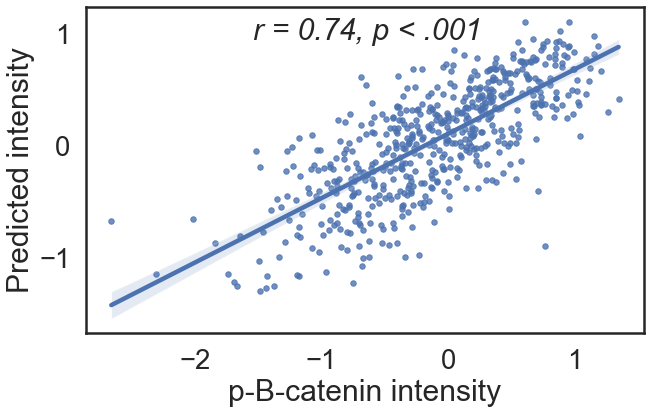

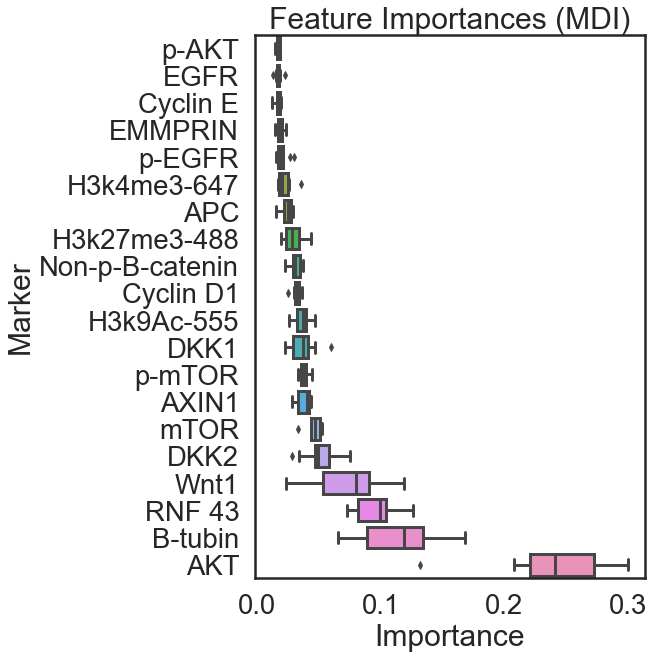

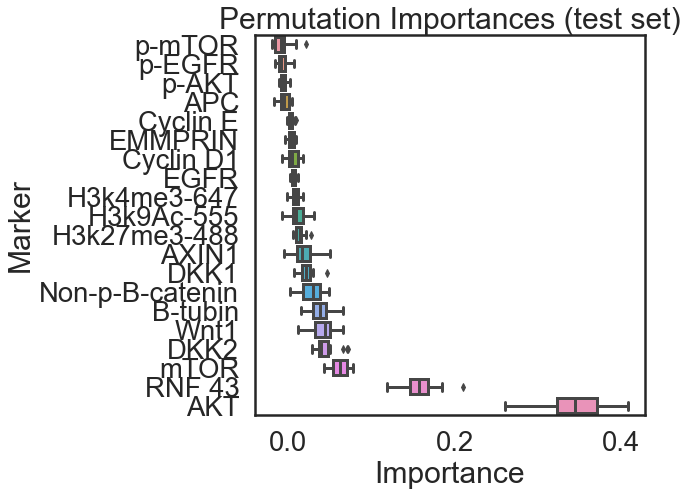

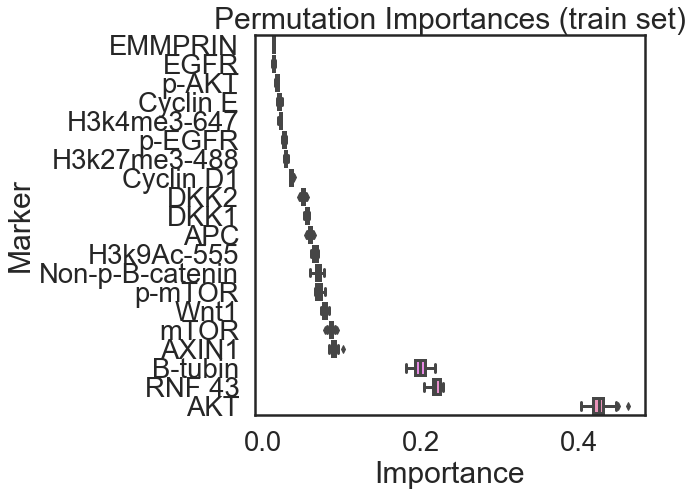

In [24]:
# p-b-catenin

X = df_cell.drop(['p-B-catenin'], axis=1).values
labels = df_cell.drop(['p-B-catenin'], axis=1).columns.tolist()

model = RandomForestRegressor(n_estimators=10, criterion='mse')
scores = cross_val_score(model, X, y_catenin, cv=5)
print(scores)

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y_catenin[train_idx], y_catenin[test_idx]

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
r_score,  p_value = stats.pearsonr(y_test, y_pred)

fig, ax = plt.subplots(figsize=(10,6))
reg = sns.regplot(y_test, y_pred, ax=ax, scatter_kws={'s': 30})
reg.set(xlabel='p-B-catenin intensity', ylabel='Predicted intensity')
reg.text(0.3, 0.9, f'r = {r_score:.2f}, p < .001', fontstyle='italic', transform=ax.transAxes)
fig.savefig(figure_dir / 'prediction' / f'p_b_catenin.png', bbox_inches="tight")

# Compute impurity importance
importances = []
kf = KFold(n_splits=10)
for train_index, test_index in kf.split(X):
    model.fit(X[train_index], y_catenin[train_index])
    importance = model.feature_importances_
    importances.append(importance)

df_importance = pd.DataFrame(importances, columns=labels).melt(var_name='Marker', value_name='Importance')
result = df_importance.groupby('Marker').aggregate(np.mean).reset_index().sort_values('Importance')

fig, ax = plt.subplots(figsize=(7,10))
bar = sns.boxplot(x='Importance', y='Marker',data=df_importance, order = result['Marker'], ax=ax)
bar.set(xlabel='Importance', ylabel='Marker')
ax.set_title("Feature Importances (MDI)")
fig.savefig(figure_dir / 'prediction' / f'p_b_catenin_imp.png', bbox_inches="tight")

# Compute Permutation importance
model.fit(X_train, y_train)
result = permutation_importance(model, X_test, y_test, n_repeats=20,
                                random_state=42, n_jobs=2)
df_importance = pd.DataFrame(result.importances.T, columns=labels).melt(var_name='Marker', value_name='Importance')
result = df_importance.groupby('Marker').aggregate(np.mean).reset_index().sort_values('Importance')


fig, ax = plt.subplots(figsize=(7,7))
bar = sns.boxplot(x='Importance', y='Marker',data=df_importance, order = result['Marker'], ax=ax)
bar.set(xlabel='Importance', ylabel='Marker')
ax.set_title("Permutation Importances (test set)")
fig.savefig(figure_dir / 'prediction' / f'p_b_catenin_imp2.png', bbox_inches="tight")


result = permutation_importance(model, X_train, y_train, n_repeats=20,
                                random_state=42, n_jobs=2)
df_importance = pd.DataFrame(result.importances.T, columns=labels).melt(var_name='Marker', value_name='Importance')
result = df_importance.groupby('Marker').aggregate(np.mean).reset_index().sort_values('Importance')


fig, ax = plt.subplots(figsize=(7,7))
bar = sns.boxplot(x='Importance', y='Marker',data=df_importance, order = result['Marker'], ax=ax)
bar.set(xlabel='Importance', ylabel='Marker')
ax.set_title("Permutation Importances (train set)")
fig.savefig(figure_dir / 'prediction' / f'p_b_catenin_imp3.png', bbox_inches="tight")

img_pred, img_true = create_prediction_img(cell_info, y_pred, y_test, masks)

for loc in img_pred.keys():
    plot_prediction_img(img_pred[loc], img_true[loc], 
                        savepath = figure_dir / 'prediction' / f'{loc}_p_b_catenin.png')


C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\sklearn\ensemble\_forest.py:388: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\sklearn\ensemble\_forest.py:388: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\sklearn\ensemble\_forest.py:388: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\sklearn\ensemble\_forest.py:388: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\thu71\Anaconda3\envs\ne

[ 0.28360991  0.40501531  0.07907049  0.14205299 -0.05800858]


C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\sklearn\ensemble\_forest.py:388: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\sklearn\ensemble\_forest.py:388: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\sklearn\ensemble\_forest.py:388: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version

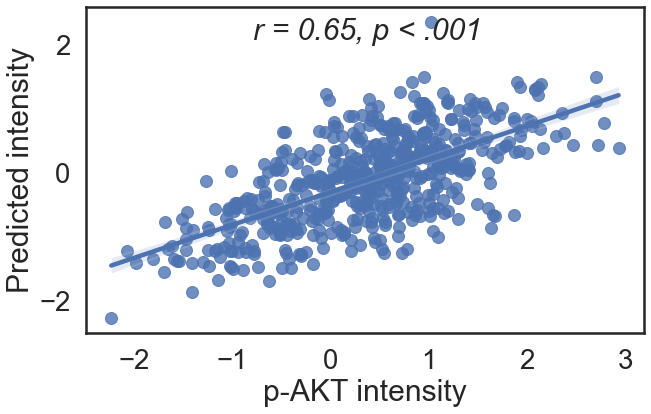

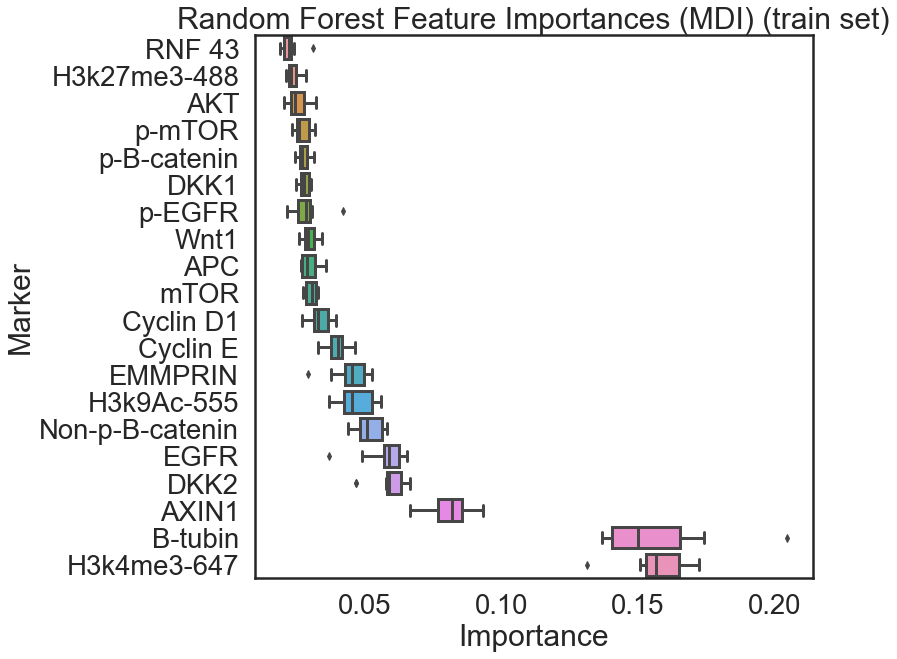

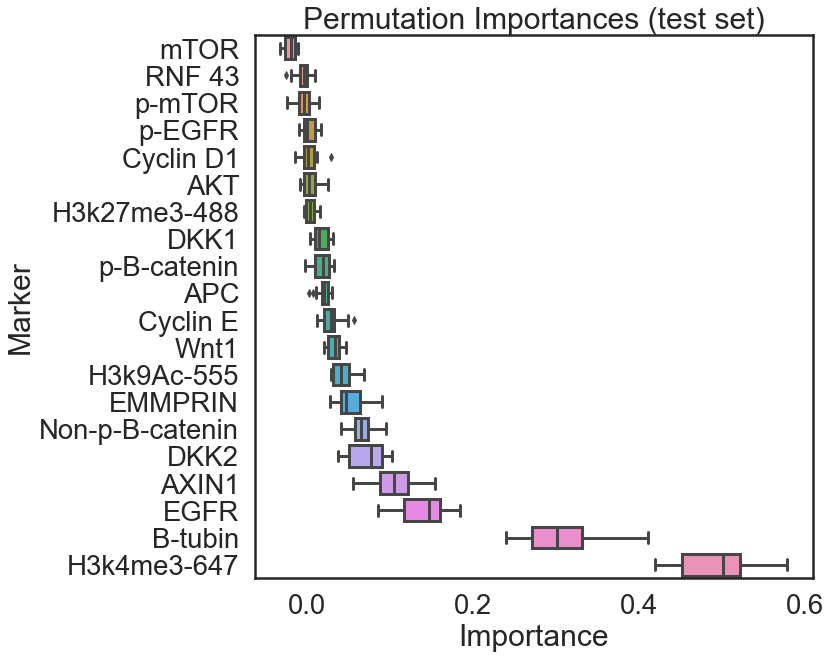

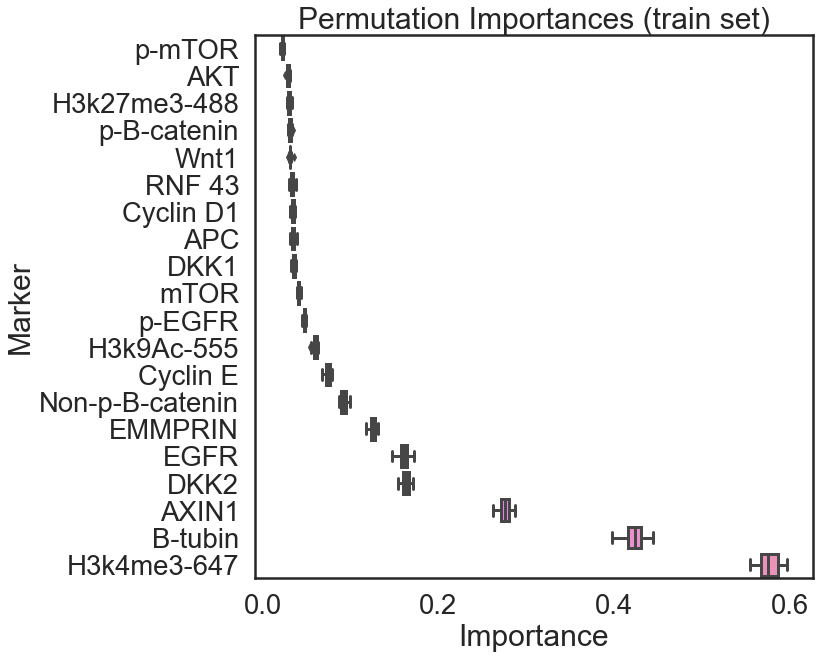

In [39]:
# p-b-catenin

X = df_cell.drop(['p-AKT'], axis=1).values
labels = df_cell.drop(['p-AKT'], axis=1).columns.tolist()

model = RandomForestRegressor(n_estimators=10, criterion='mse')
scores = cross_val_score(model, X, y_akt, cv=5)
print(scores)

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y_akt[train_idx], y_akt[test_idx]

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
r_score,  p_value = stats.pearsonr(y_test, y_pred)

fig, ax = plt.subplots(figsize=(10,6))
reg = sns.regplot(y_test, y_pred, ax=ax)
reg.set(xlabel='p-AKT intensity', ylabel='Predicted intensity')
reg.text(0.3, 0.9, f'r = {r_score:.2f}, p < .001', fontstyle='italic', transform=ax.transAxes)
fig.savefig(figure_dir / 'prediction' / f'p-AKT.png', bbox_inches="tight")

# Compute impurity importance
importances = []
kf = KFold(n_splits=10)
for train_index, test_index in kf.split(X):
    model.fit(X[train_index], y_akt[train_index])
    importance = model.feature_importances_
    importances.append(importance)

df_importance = pd.DataFrame(importances, columns=labels).melt(var_name='Marker', value_name='Importance')
result = df_importance.groupby('Marker').aggregate(np.mean).reset_index().sort_values('Importance')

fig, ax = plt.subplots(figsize=(10,10))
bar = sns.boxplot(x='Importance', y='Marker',data=df_importance, order = result['Marker'], ax=ax)
bar.set(xlabel='Importance', ylabel='Marker')
ax.set_title("Random Forest Feature Importances (MDI) (train set)")
fig.savefig(figure_dir / 'prediction' / f'p-AKT_imp.png', bbox_inches="tight")

# Compute Permutation importance
model.fit(X_train, y_train)
result = permutation_importance(model, X_test, y_test, n_repeats=20,
                                random_state=42, n_jobs=2)
df_importance = pd.DataFrame(result.importances.T, columns=labels).melt(var_name='Marker', value_name='Importance')
result = df_importance.groupby('Marker').aggregate(np.mean).reset_index().sort_values('Importance')


fig, ax = plt.subplots(figsize=(10,10))
bar = sns.boxplot(x='Importance', y='Marker',data=df_importance, order = result['Marker'], ax=ax)
bar.set(xlabel='Importance', ylabel='Marker')
ax.set_title("Permutation Importances (test set)")
fig.savefig(figure_dir / 'prediction' / f'p-AKT_imp2.png', bbox_inches="tight")


result = permutation_importance(model, X_train, y_train, n_repeats=20,
                                random_state=42, n_jobs=2)
df_importance = pd.DataFrame(result.importances.T, columns=labels).melt(var_name='Marker', value_name='Importance')
result = df_importance.groupby('Marker').aggregate(np.mean).reset_index().sort_values('Importance')


fig, ax = plt.subplots(figsize=(10,10))
bar = sns.boxplot(x='Importance', y='Marker',data=df_importance, order = result['Marker'], ax=ax)
bar.set(xlabel='Importance', ylabel='Marker')
ax.set_title("Permutation Importances (train set)")
fig.savefig(figure_dir / 'prediction' / f'p-AKT_imp3.png', bbox_inches="tight")

img_pred, img_true = create_prediction_img(cell_info, y_pred, y_test, masks)

for loc in img_pred.keys():
    plot_prediction_img(img_pred[loc], img_true[loc], 
                        savepath = figure_dir / 'prediction' / f'{loc}_p-AKT.png')


C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\sklearn\ensemble\_forest.py:388: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\sklearn\ensemble\_forest.py:388: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\sklearn\ensemble\_forest.py:388: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\sklearn\ensemble\_forest.py:388: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\thu71\Anaconda3\envs\ne

[ 0.29669322  0.10776234  0.38572019  0.2240249  -0.07557779]


C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\sklearn\ensemble\_forest.py:388: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\sklearn\ensemble\_forest.py:388: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\sklearn\ensemble\_forest.py:388: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version

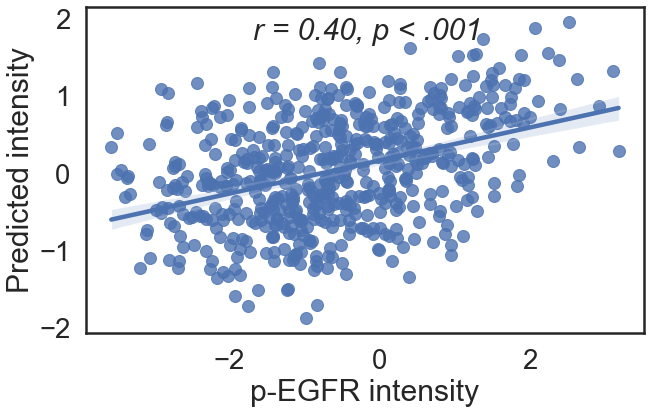

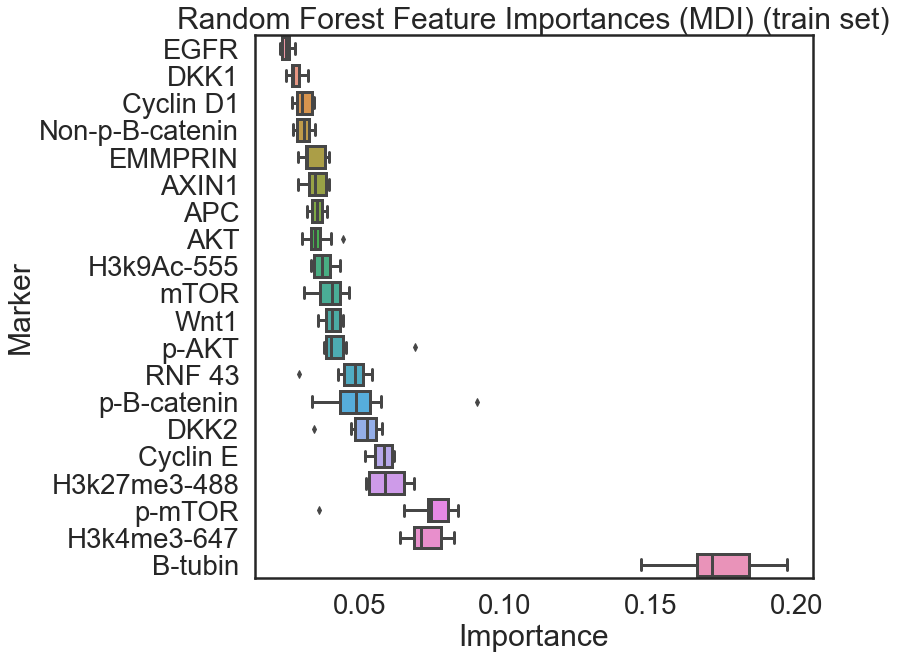

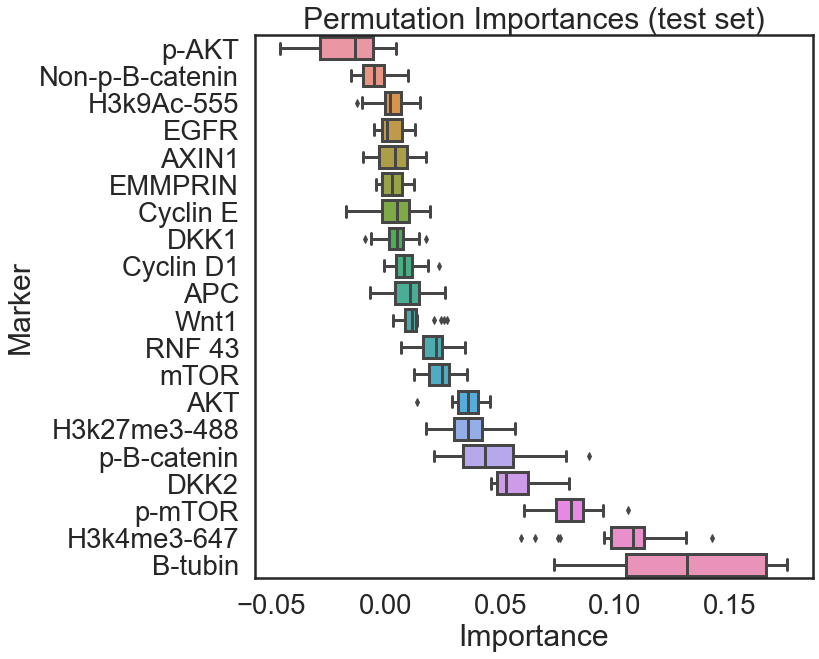

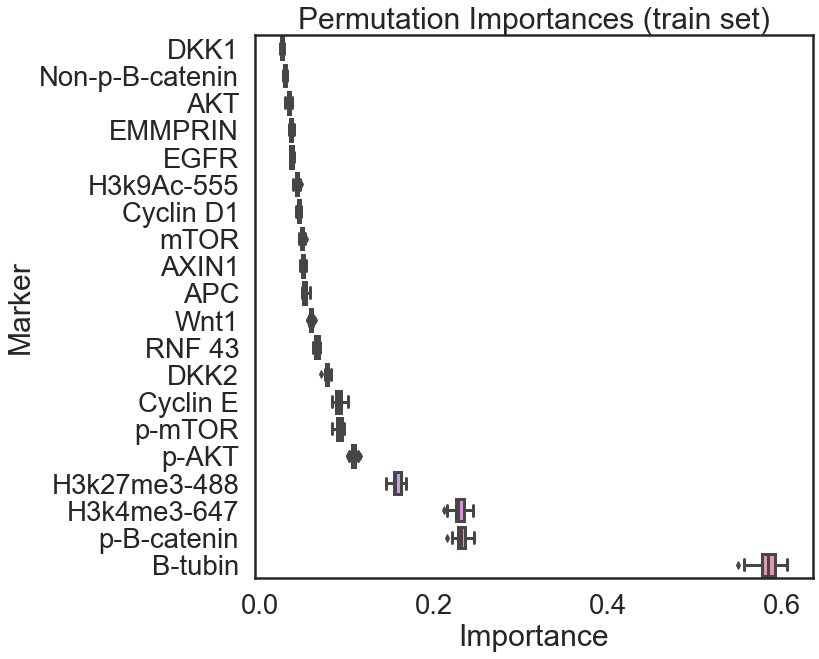

In [40]:
# p-b-catenin

X = df_cell.drop(['p-EGFR'], axis=1).values
labels = df_cell.drop(['p-EGFR'], axis=1).columns.tolist()

model = RandomForestRegressor(n_estimators=10, criterion='mse')
scores = cross_val_score(model, X, y_EGFR, cv=5)
print(scores)

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y_EGFR[train_idx], y_EGFR[test_idx]

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
r_score,  p_value = stats.pearsonr(y_test, y_pred)

fig, ax = plt.subplots(figsize=(10,6))
reg = sns.regplot(y_test, y_pred, ax=ax)
reg.set(xlabel='p-EGFR intensity', ylabel='Predicted intensity')
reg.text(0.3, 0.9, f'r = {r_score:.2f}, p < .001', fontstyle='italic', transform=ax.transAxes)
fig.savefig(figure_dir / 'prediction' / f'p-EGFR.png', bbox_inches="tight")

# Compute impurity importance
importances = []
kf = KFold(n_splits=10)
for train_index, test_index in kf.split(X):
    model.fit(X[train_index], y_EGFR[train_index])
    importance = model.feature_importances_
    importances.append(importance)

df_importance = pd.DataFrame(importances, columns=labels).melt(var_name='Marker', value_name='Importance')
result = df_importance.groupby('Marker').aggregate(np.mean).reset_index().sort_values('Importance')

fig, ax = plt.subplots(figsize=(10,10))
bar = sns.boxplot(x='Importance', y='Marker',data=df_importance, order = result['Marker'], ax=ax)
bar.set(xlabel='Importance', ylabel='Marker')
ax.set_title("Random Forest Feature Importances (MDI) (train set)")
fig.savefig(figure_dir / 'prediction' / f'p-EGFR_imp.png', bbox_inches="tight")

# Compute Permutation importance
model.fit(X_train, y_train)
result = permutation_importance(model, X_test, y_test, n_repeats=20,
                                random_state=42, n_jobs=2)
df_importance = pd.DataFrame(result.importances.T, columns=labels).melt(var_name='Marker', value_name='Importance')
result = df_importance.groupby('Marker').aggregate(np.mean).reset_index().sort_values('Importance')


fig, ax = plt.subplots(figsize=(10,10))
bar = sns.boxplot(x='Importance', y='Marker',data=df_importance, order = result['Marker'], ax=ax)
bar.set(xlabel='Importance', ylabel='Marker')
ax.set_title("Permutation Importances (test set)")
fig.savefig(figure_dir / 'prediction' / f'p-EGFR_imp2.png', bbox_inches="tight")


result = permutation_importance(model, X_train, y_train, n_repeats=20,
                                random_state=42, n_jobs=2)
df_importance = pd.DataFrame(result.importances.T, columns=labels).melt(var_name='Marker', value_name='Importance')
result = df_importance.groupby('Marker').aggregate(np.mean).reset_index().sort_values('Importance')


fig, ax = plt.subplots(figsize=(10,10))
bar = sns.boxplot(x='Importance', y='Marker',data=df_importance, order = result['Marker'], ax=ax)
bar.set(xlabel='Importance', ylabel='Marker')
ax.set_title("Permutation Importances (train set)")
fig.savefig(figure_dir / 'prediction' / f'p-EGFR_imp3.png', bbox_inches="tight")

img_pred, img_true = create_prediction_img(cell_info, y_pred, y_test, masks)

for loc in img_pred.keys():
    plot_prediction_img(img_pred[loc], img_true[loc], 
                        savepath = figure_dir / 'prediction' / f'{loc}_p-EGFR.png')


C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\sklearn\ensemble\_forest.py:388: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\sklearn\ensemble\_forest.py:388: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\sklearn\ensemble\_forest.py:388: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\sklearn\ensemble\_forest.py:388: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\thu71\Anaconda3\envs\ne

[ 0.44462715 -0.0499908   0.36229898  0.40313067  0.08177933]


C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\sklearn\ensemble\_forest.py:388: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\sklearn\ensemble\_forest.py:388: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\sklearn\ensemble\_forest.py:388: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version

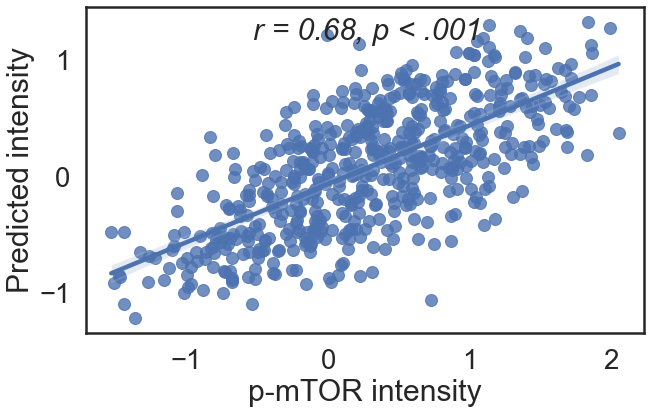

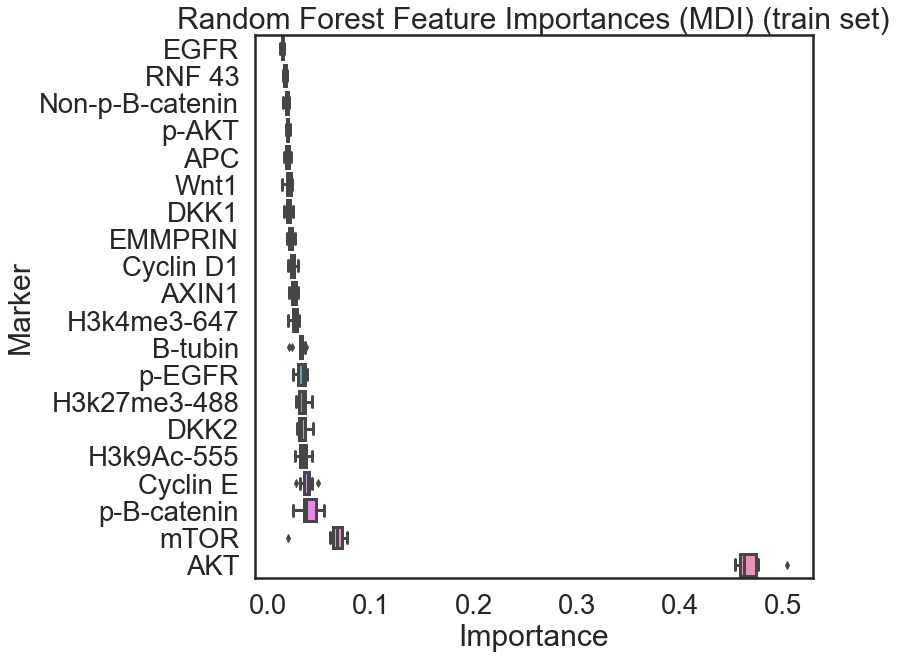

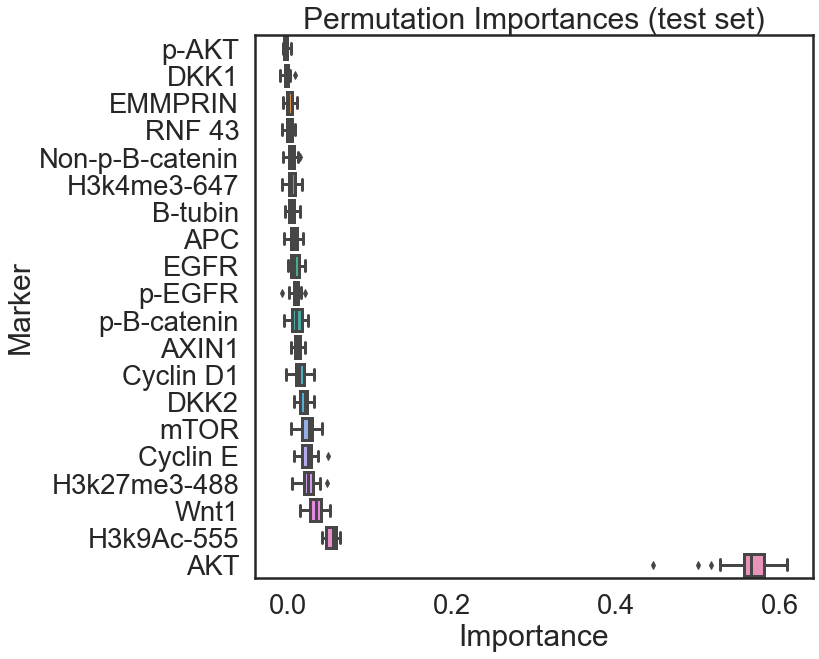

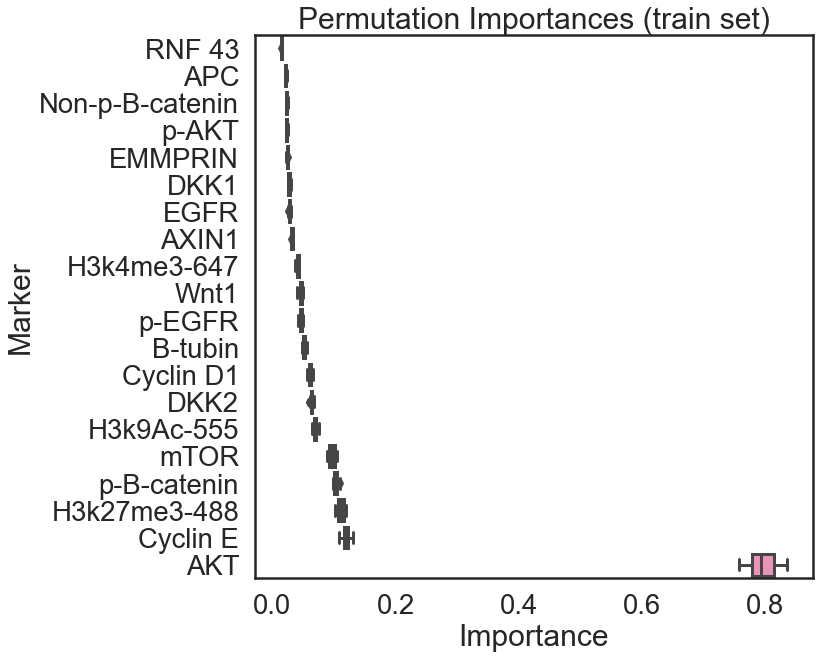

In [41]:
# p-b-catenin

X = df_cell.drop(['p-mTOR'], axis=1).values
labels = df_cell.drop(['p-mTOR'], axis=1).columns.tolist()

model = RandomForestRegressor(n_estimators=10, criterion='mse')
scores = cross_val_score(model, X, y_tor, cv=5)
print(scores)

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y_tor[train_idx], y_tor[test_idx]

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
r_score,  p_value = stats.pearsonr(y_test, y_pred)

fig, ax = plt.subplots(figsize=(10,6))
reg = sns.regplot(y_test, y_pred, ax=ax)
reg.set(xlabel='p-mTOR intensity', ylabel='Predicted intensity')
reg.text(0.3, 0.9, f'r = {r_score:.2f}, p < .001', fontstyle='italic', transform=ax.transAxes)
fig.savefig(figure_dir / 'prediction' / f'p-mTOR.png', bbox_inches="tight")

# Compute impurity importance
importances = []
kf = KFold(n_splits=10)
for train_index, test_index in kf.split(X):
    model.fit(X[train_index], y_tor[train_index])
    importance = model.feature_importances_
    importances.append(importance)

df_importance = pd.DataFrame(importances, columns=labels).melt(var_name='Marker', value_name='Importance')
result = df_importance.groupby('Marker').aggregate(np.mean).reset_index().sort_values('Importance')

fig, ax = plt.subplots(figsize=(10,10))
bar = sns.boxplot(x='Importance', y='Marker',data=df_importance, order = result['Marker'], ax=ax)
bar.set(xlabel='Importance', ylabel='Marker')
ax.set_title("Random Forest Feature Importances (MDI) (train set)")
fig.savefig(figure_dir / 'prediction' / f'p-mTOR_imp.png', bbox_inches="tight")

# Compute Permutation importance
model.fit(X_train, y_train)
result = permutation_importance(model, X_test, y_test, n_repeats=20,
                                random_state=42, n_jobs=2)
df_importance = pd.DataFrame(result.importances.T, columns=labels).melt(var_name='Marker', value_name='Importance')
result = df_importance.groupby('Marker').aggregate(np.mean).reset_index().sort_values('Importance')


fig, ax = plt.subplots(figsize=(10,10))
bar = sns.boxplot(x='Importance', y='Marker',data=df_importance, order = result['Marker'], ax=ax)
bar.set(xlabel='Importance', ylabel='Marker')
ax.set_title("Permutation Importances (test set)")
fig.savefig(figure_dir / 'prediction' / f'p-mTOR_imp2.png', bbox_inches="tight")


result = permutation_importance(model, X_train, y_train, n_repeats=20,
                                random_state=42, n_jobs=2)
df_importance = pd.DataFrame(result.importances.T, columns=labels).melt(var_name='Marker', value_name='Importance')
result = df_importance.groupby('Marker').aggregate(np.mean).reset_index().sort_values('Importance')


fig, ax = plt.subplots(figsize=(10,10))
bar = sns.boxplot(x='Importance', y='Marker',data=df_importance, order = result['Marker'], ax=ax)
bar.set(xlabel='Importance', ylabel='Marker')
ax.set_title("Permutation Importances (train set)")
fig.savefig(figure_dir / 'prediction' / f'p-mTOR_imp3.png', bbox_inches="tight")

img_pred, img_true = create_prediction_img(cell_info, y_pred, y_test, masks)

for loc in img_pred.keys():
    plot_prediction_img(img_pred[loc], img_true[loc], 
                        savepath = figure_dir / 'prediction' / f'{loc}_p-mTOR.png')
